# Dislib tutorial

This tutorial will show the basics of using [dislib](https://dislib.bsc.es).


## Setup


First, we need to start an interactive PyCOMPSs session:

In [1]:
import pycompss.interactive as ipycompss
import os
if 'BINDER_SERVICE_HOST' in os.environ:
    ipycompss.start(graph=True,
                    project_xml='../xml/project.xml',
                    resources_xml='../xml/resources.xml')
else:
    ipycompss.start(graph=True, monitor=1000)

******************************************************
*************** PyCOMPSs Interactive *****************
******************************************************
*          .-~~-.--.           _____       _______   *
*         :         )         |____ \     /  ___  \  *
*   .~ ~ -.\       /.- ~~ .     ___) |    | (___) |  *
*   >       `.   .'       <    / ___/      > ___ <   *
*  (         .- -.         )  | |___   _  | (___) |  *
*   `- -.-~  `- -'  ~-.- -'   |_____| |_| \_______/  *
*     (        :        )           _ _ .-:          *
*      ~--.    :    .--~        .-~  .-~  }          *
*          ~-.-^-.-~ \_      .~  .-~   .~            *
*                   \ \ '     \ '_ _ -~              *
*                    \`.\`.    //                    *
*           . - ~ ~-.__\`.\`-.//                     *
*       .-~   . - ~  }~ ~ ~-.~-.                     *
*     .' .-~      .-~       :/~-.~-./:               *
*    /_~_ _ . - ~                 ~-.~-._            *
*         

Next, we import dislib and we are all set to start working!

In [2]:
import dislib as ds

## Distributed arrays

The main data structure in dislib is the distributed array (or ds-array). These arrays are a distributed representation of a 2-dimensional array that can be operated as a regular Python object. Usually, rows in the array represent samples, while columns represent features.

To create a random array we can run the following NumPy-like command:

In [3]:
x = ds.random_array(shape=(500, 500), block_size=(100, 100))
print(x.shape)
x

(500, 500)


ds-array(blocks=(...), top_left_shape=(100, 100), reg_shape=(100, 100), shape=(500, 500), sparse=False)

Now `x` is a 500x500 ds-array of random numbers stored in blocks of 100x100 elements. Note that `x` is not stored in memory. Instead, `random_array` generates the contents of the array in tasks that are usually executed remotely. This allows the creation of really big arrays.

The content of `x` is a list of `Futures` that represent the actual data (wherever it is stored).

To see this, we can access the `_blocks` field of `x`:

In [4]:
x._blocks[0][0]

`block_size` is useful to control the granularity of dislib algorithms.

To retrieve the actual contents of `x`, we use `collect`, which synchronizes the data and returns the equivalent NumPy array:

In [5]:
x.collect()

array([[0.46389804, 0.18475889, 0.63682499, ..., 0.82056621, 0.08922377,
        0.14262519],
       [0.18467109, 0.51491529, 0.4825426 , ..., 0.39301796, 0.64854777,
        0.2094461 ],
       [0.26405691, 0.60016665, 0.94703456, ..., 0.2632704 , 0.49704007,
        0.56586544],
       ...,
       [0.20867451, 0.577938  , 0.46875228, ..., 0.47120027, 0.1558274 ,
        0.16836698],
       [0.8991298 , 0.28668497, 0.57129636, ..., 0.19682853, 0.31584722,
        0.90844382],
       [0.09057572, 0.92021344, 0.14017232, ..., 0.80701223, 0.48778998,
        0.32896373]])

Another way of creating ds-arrays is using array-like structures like NumPy arrays or lists:

In [6]:
x1 = ds.array([[1, 2, 3], [4, 5, 6]], block_size=(1, 3))
x1

ds-array(blocks=(...), top_left_shape=(1, 3), reg_shape=(1, 3), shape=(2, 3), sparse=False)

Distributed arrays can also store sparse data in CSR format:

In [7]:
from scipy.sparse import csr_matrix

sp = csr_matrix([[0, 0, 1], [1, 0, 1]])
x_sp = ds.array(sp, block_size=(1, 3))
x_sp

ds-array(blocks=(...), top_left_shape=(1, 3), reg_shape=(1, 3), shape=(2, 3), sparse=True)

In this case, `collect` returns a CSR matrix as well:

In [8]:
x_sp.collect()

<2x3 sparse matrix of type '<class 'numpy.int64'>'
	with 3 stored elements in Compressed Sparse Row format>

### Loading data

A typical way of creating ds-arrays is to load data from disk. Dislib currently supports reading data in CSV and SVMLight formats like this:

In [9]:
x, y = ds.load_svmlight_file("./files/libsvm/1", block_size=(20, 100), n_features=780, store_sparse=True)

print(x)

csv = ds.load_txt_file("./files/csv/1", block_size=(500, 122))

print(csv)

ds-array(blocks=(...), top_left_shape=(20, 100), reg_shape=(20, 100), shape=(61, 780), sparse=True)
ds-array(blocks=(...), top_left_shape=(500, 122), reg_shape=(500, 122), shape=(4235, 122), sparse=False)


### Slicing

Similar to NumPy, ds-arrays support the following types of slicing:

(Note that slicing a ds-array creates a new ds-array)

In [10]:
x = ds.random_array((50, 50), (10, 10))

Get a single row:

In [11]:
x[4]

ds-array(blocks=(...), top_left_shape=(10, 10), reg_shape=(10, 10), shape=(1, 50), sparse=False)

Get a single element:

In [12]:
x[2, 3]

ds-array(blocks=(...), top_left_shape=(1, 1), reg_shape=(1, 1), shape=(1, 1), sparse=False)

Get a set of rows or a set of columns:

In [13]:
# Consecutive rows
print(x[10:20])

# Consecutive columns
print(x[:, 10:20])

# Non consecutive rows
print(x[[3, 7, 22]])

# Non consecutive columns
print(x[:, [5, 9, 48]])

ds-array(blocks=(...), top_left_shape=(10, 10), reg_shape=(10, 10), shape=(10, 50), sparse=False)
ds-array(blocks=(...), top_left_shape=(10, 10), reg_shape=(10, 10), shape=(50, 10), sparse=False)
ds-array(blocks=(...), top_left_shape=(10, 10), reg_shape=(10, 10), shape=(3, 50), sparse=False)
ds-array(blocks=(...), top_left_shape=(10, 10), reg_shape=(10, 10), shape=(50, 3), sparse=False)


Get any set of elements:

In [14]:
x[0:5, 40:45]

ds-array(blocks=(...), top_left_shape=(10, 10), reg_shape=(10, 10), shape=(5, 5), sparse=False)

### Other functions

Apart from this, ds-arrays also provide other useful operations like `transpose` and `mean`:

In [15]:
x.mean(axis=0).collect()

array([0.46489277, 0.55743969, 0.4958683 , 0.51345327, 0.51121926,
       0.49169827, 0.5643076 , 0.48608947, 0.55894632, 0.54093422,
       0.52207093, 0.45836864, 0.50827907, 0.4646198 , 0.62662217,
       0.56470828, 0.47351439, 0.52087689, 0.47866339, 0.45134683,
       0.4853953 , 0.5226501 , 0.49171978, 0.54341068, 0.50317663,
       0.5515547 , 0.43771184, 0.56820752, 0.46277316, 0.45373204,
       0.54790771, 0.45907799, 0.54091248, 0.46659185, 0.51090935,
       0.54891673, 0.48093633, 0.52085058, 0.49205259, 0.47641245,
       0.52161665, 0.47131924, 0.48740917, 0.53032101, 0.46797002,
       0.4906833 , 0.49462882, 0.4751082 , 0.44731525, 0.53273821])

In [16]:
x.transpose().collect()

array([[0.63458986, 0.55647416, 0.49031327, ..., 0.24550204, 0.26148174,
        0.89615153],
       [0.06741111, 0.08350163, 0.56969848, ..., 0.98715921, 0.77249552,
        0.40096147],
       [0.32440531, 0.91125297, 0.49892465, ..., 0.54502034, 0.45320279,
        0.32308287],
       ...,
       [0.15006294, 0.51974144, 0.02239202, ..., 0.77566778, 0.38929851,
        0.53464162],
       [0.93703416, 0.93083692, 0.11790326, ..., 0.34301266, 0.87804966,
        0.68488102],
       [0.9759782 , 0.52213226, 0.93045572, ..., 0.09560227, 0.95254917,
        0.74387733]])

## Machine learning with dislib

Dislib provides an estimator-based API very similar to [scikit-learn](https://scikit-learn.org/stable/). To run an algorithm, we first create an estimator. For example, a K-means estimator:

In [17]:
from dislib.cluster import KMeans

km = KMeans(n_clusters=3)

Now, we create a ds-array with some blob data, and fit the estimator:

In [18]:
from sklearn.datasets import make_blobs

# create ds-array
x, y = make_blobs(n_samples=1500)
x_ds = ds.array(x, block_size=(500, 2))

km.fit(x_ds)

KMeans(arity=50, init='random', max_iter=10, n_clusters=3,
       random_state=RandomState(MT19937) at 0x7FC7B0108BA0, tol=0.0001,
       verbose=False)

Finally, we can make predictions on new (or the same) data:

In [19]:
y_pred = km.predict(x_ds)
y_pred

ds-array(blocks=(...), top_left_shape=(500, 1), reg_shape=(500, 1), shape=(1500, 1), sparse=False)

`y_pred` is a ds-array of predicted labels for `x_ds`

Let's plot the results

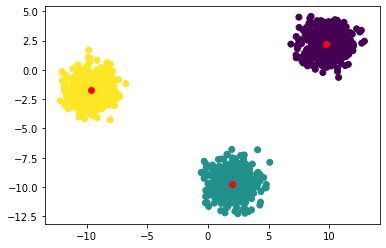

In [20]:
%matplotlib inline
import matplotlib.pyplot as plt


centers = km.centers

# set the color of each sample to the predicted label
plt.scatter(x[:, 0], x[:, 1], c=y_pred.collect())

# plot the computed centers in red
plt.scatter(centers[:, 0], centers[:, 1], c='red')

Note that we need to call `y_pred.collect()` to retrieve the actual labels and plot them. The rest is the same as if we were using scikit-learn.

Now let's try a more complex example that uses some preprocessing tools.

First, we load a classification data set from scikit-learn into ds-arrays. 

Note that this step is only necessary for demonstration purposes. Ideally, your data should be already loaded in ds-arrays.

In [21]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

x, y = load_breast_cancer(return_X_y=True)

x_train, x_test, y_train, y_test = train_test_split(x, y)

x_train = ds.array(x_train, block_size=(100, 10))
y_train = ds.array(y_train.reshape(-1, 1), block_size=(100, 1))

x_test = ds.array(x_test, block_size=(100, 10))
y_test = ds.array(y_test.reshape(-1, 1), block_size=(100, 1))

Next, we can see how support vector machines perform in classifying the data. We first fit the model (ignore any warnings in this step):

In [22]:
from dislib.classification import CascadeSVM

csvm = CascadeSVM()

csvm.fit(x_train, y_train)

/usr/lib/python3.6/site-packages/dislib-0.4.0-py3.6.egg/dislib/classification/csvm/base.py:374: RuntimeWarning: overflow encountered in exp
  k = np.exp(k)
/usr/lib/python3.6/site-packages/dislib-0.4.0-py3.6.egg/dislib/classification/csvm/base.py:342: RuntimeWarning: invalid value encountered in double_scalars
  delta = np.abs((w - self._last_w) / self._last_w)


CascadeSVM(c=1, cascade_arity=2, check_convergence=True, gamma='auto',
           kernel='rbf', max_iter=5, random_state=None, tol=0.001,
           verbose=False)

and now we can make predictions on new data using `csvm.predict()`, or we can get the model accuracy on the test set with:

In [23]:
score = csvm.score(x_test, y_test)

`score` represents the classifier accuracy, however, it is returned as a `Future`. We need to synchronize to get the actual value:

In [24]:
from pycompss.api.api import compss_wait_on

print(compss_wait_on(score))

0.6433566433566433


The accuracy should be around 0.6, which is not very good. We can scale the data before classification to improve accuracy. This can be achieved using dislib's `StandardScaler`.

The `StandardScaler` provides the same API as other estimators. In this case, however, instead of making predictions on new data, we transform it:

In [25]:
from dislib.preprocessing import StandardScaler

sc = StandardScaler()

# fit the scaler with train data and transform it
scaled_train = sc.fit_transform(x_train)

# transform test data
scaled_test = sc.transform(x_test)

Now `scaled_train` and `scaled_test` are the scaled samples. Let's see how SVM perfroms now.

In [26]:
csvm.fit(scaled_train, y_train)
score = csvm.score(scaled_test, y_test)
print(compss_wait_on(score))

0.972027972027972


The new accuracy should be around 0.9, which is a great improvement!

### Close the session

To finish the session, we need to stop PyCOMPSs:

In [27]:
ipycompss.stop()

****************************************************
*************** STOPPING PyCOMPSs ******************
****************************************************
         have not been brought to the master.
****************************************************
